In [8]:
def price_ss(kappa, sigma_chi, risk_chi, mu_xi, sigma_xi, risk_xi, rho, chi0, xi0, N, dt, trialno):
    np.random.seed(54321)
    chi = np.zeros((trialno, N + 1))
    xi = np.zeros((trialno, N + 1))

    # Valores iniciais
    chi[:, 0] = chi0
    xi[:, 0] = xi0

    for i in range(1, N+1):
        epsilon_xi = np.random.randn(trialno)  # Perturbação aleatória

        xi[:, i] = xi[:, i - 1] + (mu_xi - risk_xi) * dt + sigma_xi * epsilon_xi * np.sqrt(dt)  # long-term

        epsilon_chi = epsilon_xi * rho + np.random.randn(trialno) * np.sqrt(1 - rho**2)
        
        chi[:, i] = chi[:, i - 1] * np.exp(-kappa * dt) - (1 - np.exp(-kappa * dt)) * (risk_chi / kappa) \
        + sigma_chi * epsilon_chi * np.sqrt((1 - np.exp(-2 * kappa * dt)) / (2 * kappa)) # short-term
        

    return chi, xi

In [9]:
trialno = 10000
T = 10
dt = 1/5                   # granularity of time-period 
time = np.arange(dt, T+dt, dt)  # time points
N = len(time)                   # number of time intervals

#chi, xi = price_ss(kappa, sigmachi, riskchi, muxi, sigmaxi, riskxi, rho, chi0, xi0, N, trialno)
chi, xi = price_ss(param_optimized[0], param_optimized[1], param_optimized[2], param_optimized[3], 
                    param_optimized[4], param_optimized[5],param_optimized[6], Xtgivtvec[-1, 0], Xtgivtvec[-1, 1],
                    N, dt, trialno)

##############################################################################################################################
# Cálculo das estatísticas ao longo das colunas (tempo)
p90 = np.percentile(np.exp(chi + xi), 90, axis=0)
#p50 = np.percentile(np.exp(chi + xi), 50, axis=0)
media = np.mean(np.exp(chi + xi), axis=0)
p10 = np.percentile(np.exp(chi + xi), 10, axis=0)

plt.figure(figsize=(8, 4))
n = int(T/dt)
t = np.linspace(0, T, n+1)
#tt = t*dt
#plt.plot(t, np.exp(chi + xi).T, linewidth=0.5, color='k')
plt.plot(t, np.exp(chi + xi).T[:,0:10], linewidth=0.8, color='gray')

plt.plot(t, p90, label="P90", color="teal", lw=3)
#plt.plot(t, p50, label="P50", color="yellow", linewidth=3)
plt.plot(t, media, label="Mean", color="goldenrod", lw=3)
plt.plot(t, p10, label="P10", color="darkred", lw=3)
#plt.title('Oil price simulation results and confidence bands')
plt.ylabel('Oil price (US$/bbl)')
plt.xlabel('Year')
plt.legend()
plt.xticks(range(int(min(t)), int(max(t)) + 1))
plt.grid(lw=0.1, color="0.94")

# Salvar figura
output_path = r"C:\Users\calva\OneDrive\Documentos\Doutorado\paper_com_Bratvold\sn-article-template\Price_profile.eps"
plt.savefig(output_path, format='eps', dpi=300, bbox_inches='tight')

# Mostrar
plt.show()
plt.close()

NameError: name 'Xtgivtvec' is not defined

#######################################################################################################################################################

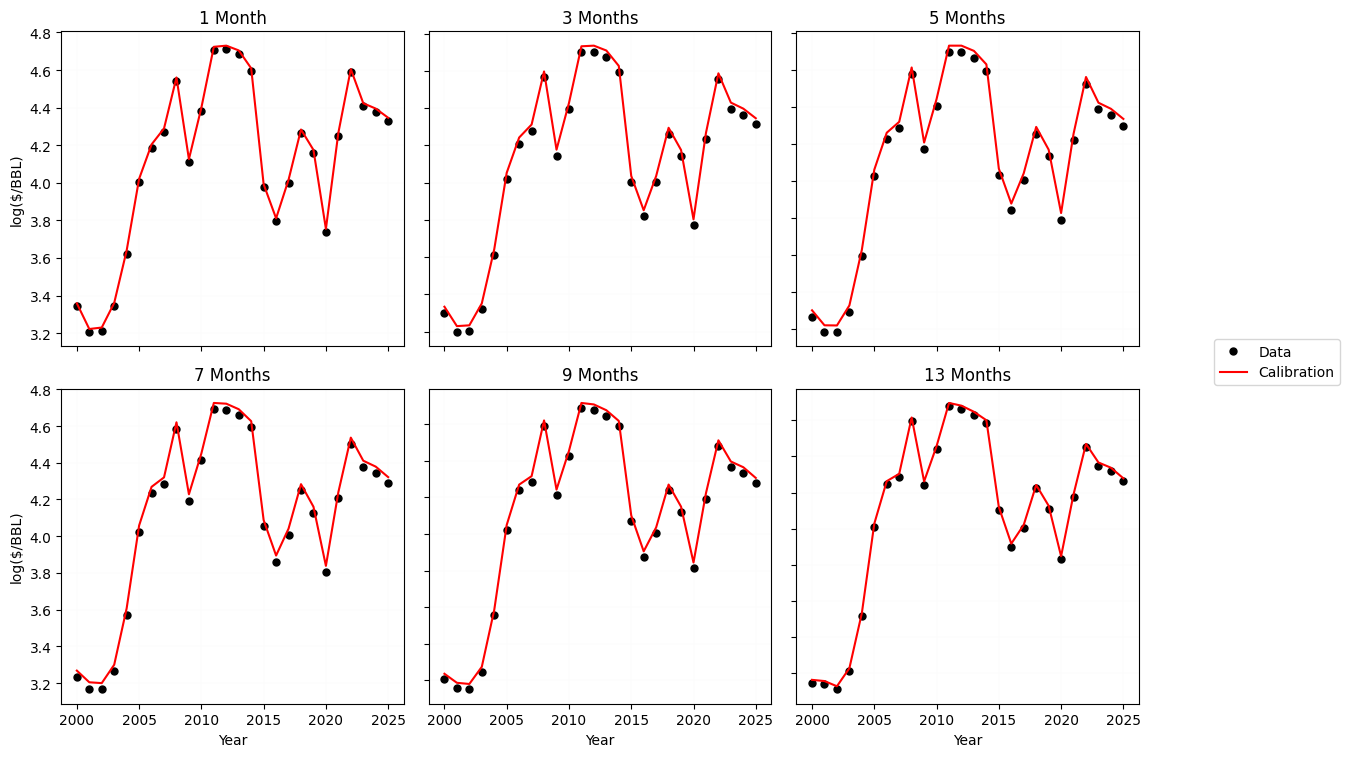

<Figure size 640x480 with 0 Axes>

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. LER OS DADOS (ajuste o caminho se necessário)
dados = pd.read_csv('price_log_1_3_5_7_9_13.csv', header=None)
n_weeks = len(dados)
data_inicial = pd.to_datetime('2000-01-07')
datas = pd.date_range(data_inicial, periods=n_weeks, freq='W-FRI')
dados['Year'] = datas.year
medias_anuais = dados.groupby('Year').mean()
anos = medias_anuais.index.values

labels = ['1 Month', '3 Months', '5 Months', '7 Months', '9 Months', '13 Months']
taus_meses = [1, 3, 5, 7, 9, 13]  # maturidades em meses
taus = [x / 12 for x in taus_meses]  # em anos

params = {
    'kappa':        param_optimized[0],
    'sigma_chi':    param_optimized[1],
    'risk_chi':     param_optimized[2],
    'mu_xi':        param_optimized[3],
    'sigma_xi':     param_optimized[4],
    'risk_xi':      param_optimized[5],
    'rho':          param_optimized[6],
    'chi0':         param_optimized[7],
    'xi0':          param_optimized[8]
}

# 3. FÓRMULA FECHADA PARA A(T) E lnF
def A_SchwartzSmith(params, T):
    mu_xi = params['mu_xi']
    risk_xi = params['risk_xi']
    kappa = params['kappa']
    risk_chi = params['risk_chi']
    sigma_chi = params['sigma_chi']
    sigma_xi = params['sigma_xi']
    rho = params['rho']
    term1 = (mu_xi - risk_xi) * T
    term2 = -(1 - np.exp(-kappa*T)) * (risk_chi / kappa)
    term3 = 0.5 * (
        (1 - np.exp(-2*kappa*T)) * (sigma_chi**2) / (2*kappa)
        + (sigma_xi**2) * T
        + 2 * (1 - np.exp(-2*kappa*T)) * rho * sigma_chi * sigma_xi / kappa
    )
    return term1 + term2 + term3

def lnF_SchwartzSmith(chi0, xi0, params, T):
    kappa = params['kappa']
    return np.exp(-kappa*T)*chi0 + xi0 + A_SchwartzSmith(params, T)

# 4. PLOTAGEM
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=False)
lines = []
labels_legend = []

for i, label in enumerate(labels):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    # Dados reais
    l1, = ax.plot(anos, medias_anuais.iloc[:, i], 'ko', label='Data', markersize=5)
    # Modelo calibrado
    lnF_list = []
    for j, ano in enumerate(anos):
        xi0 = float(medias_anuais.iloc[j, i])
        chi0 = 0
        tau = taus[i]
        lnF = lnF_SchwartzSmith(chi0, xi0, params, tau)
        lnF_list.append(lnF)
    l2, = ax.plot(anos, lnF_list, 'r-', label='Calibration', linewidth=1.5)
    ax.set_title(label)
    ax.grid(lw=0.1, color="0.94")

    # X label só na última linha
    if row == 1:
        ax.set_xlabel('Year')
    else:
        ax.set_xticklabels([])

    # Y label só na primeira coluna
    if col == 0:
        ax.set_ylabel('log($/BBL)')
    else:
        ax.set_yticklabels([])

    # Só coleta legendas na primeira subplot
    if i == 0:
        lines.extend([l1, l2])
        labels_legend.extend([l1.get_label(), l2.get_label()])

# Legenda externa à direita
fig.legend(
    handles=lines,
    labels=labels_legend,
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    fontsize=10
)

#fig.suptitle('Oil Price Calibration', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.97, 0.96])  # Deixa espaço para a legenda

# Salvar figura
output_path = r"C:\Users\calva\OneDrive\Documentos\Doutorado\paper_com_Bratvold\sn-article-template\Price_Calibration.eps"
plt.savefig(output_path, format='eps', dpi=300, bbox_inches='tight')

# Mostrar
plt.show()
plt.close()